In [1]:
# prompt: unrar train.rar file

!unrar x train.rar

Streaming output truncated to the last 5000 lines.
Extracting  train/cat.7698.jpg                                            64%  OK 
Extracting  train/cat.7699.jpg                                            64%  OK 
Extracting  train/cat.77.jpg                                              64%  OK 
Extracting  train/cat.770.jpg                                             64%  OK 
Extracting  train/cat.7700.jpg                                            64%  OK 
Extracting  train/cat.7701.jpg                                            64%  OK 
Extracting  train/cat.7702.jpg                                            64%  OK 
Extracting  train/cat.7703.jpg                                            64%  OK 
Extracting  train/cat.7704.jpg                                            64%  OK 
Extracting  train/cat.7705.jpg                                            64%  OK 
Extracting  train/cat.7706.jp

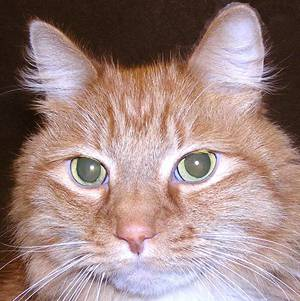

In [2]:
# prompt: load the first image from the train directory

import os
import cv2
from google.colab.patches import cv2_imshow

train_dir = 'train'  # Assuming 'train' is the directory where images are extracted

# Find the first image file in the directory
for filename in os.listdir(train_dir):
  if filename.endswith(('.jpg', '.jpeg', '.png')):
    image_path = os.path.join(train_dir, filename)
    image = cv2.imread(image_path)

    if image is not None:
      cv2_imshow(image)
      break  # Stop after loading the first image

Removing the corrupted images

In [ ]:
import os
from PIL import Image

def find_and_delete_corrupted_images(directory):


    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)

        # Skip directories
        if os.path.isdir(file_path):
            continue

        try:
            # Attempt to open the file as an image
            with Image.open(file_path) as img:
                img.verify()  # Verify that it is a valid image
        except (IOError, SyntaxError) as e:
            # If an error occurs, the file is not a valid image
            print(f"Deleting corrupted or invalid image: {file_path}")
            os.remove(file_path)

# Replace 'your_directory_path' with the path to your image directory
image_directory = "./train/"
find_and_delete_corrupted_images(image_directory)


Moving cat images to cats folder and dog images to dogs folder


In [3]:
import os
import shutil

# Define the source directory and target folders
source_dir = "./train/" # Path to the 'train' folder
cats_folder = "./cats" # 'cats' folder in the parent directory
dogs_folder = "./dogs"  # 'dogs' folder in the parent directory

# Create target folders if they don't exist
os.makedirs(cats_folder, exist_ok=True)
os.makedirs(dogs_folder, exist_ok=True)

# Iterate through the files in the 'train' directory
for file_name in os.listdir(source_dir):

    file_path = os.path.join(source_dir, file_name)  # Full path to the file
    # Check if it's a file and starts with "cat" or "dog"
    if file_name.startswith("cat") and os.path.isfile(file_path):
        shutil.copy(file_path, cats_folder)
        # print(f"Copied {file_name} to {cats_folder}")
    elif file_name.startswith("dog") and os.path.isfile(file_path):
        shutil.copy(file_path, dogs_folder)
        # print(f"Copied {file_name} to {dogs_folder}")


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [5]:
def load_images_from_folder(folder, label, target_size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img) / 255.0  # Normalize the image
        images.append(img_array)
        labels.append(label)
    return np.array(images), np.array(labels)

# Paths to image folders
cat_folder = './cats/'
dog_folder = './dogs/'

# Load images
cat_images, cat_labels = load_images_from_folder(cat_folder, label=0)
dog_images, dog_labels = load_images_from_folder(dog_folder, label=1)

# Combine datasets
X = np.concatenate((cat_images, dog_images), axis=0)
y = np.concatenate((cat_labels, dog_labels), axis=0)

cat_images.shape, dog_images.shape




((12500, 128, 128, 3), (2442, 128, 128, 3))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=20)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


374/374 ━━━━━━━━━━━━━━━━━━━━ 72s 168ms/step - accuracy: 0.8410 - loss: 0.4649 - val_accuracy: 0.8491 - val_loss: 0.4125
Epoch 2/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 63s 137ms/step - accuracy: 0.8334 - loss: 0.4351 - val_accuracy: 0.8187 - val_loss: 0.4492
Epoch 3/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 53s 141ms/step - accuracy: 0.8414 - loss: 0.4182 - val_accuracy: 0.8421 - val_loss: 0.4160
Epoch 4/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 81s 138ms/step - accuracy: 0.8516 - loss: 0.3896 - val_accuracy: 0.8725 - val_loss: 0.3466
Epoch 5/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 56s 146ms/step - accuracy: 0.8408 - loss: 0.3967 - val_accuracy: 0.8745 - val_loss: 0.3257
Epoch 6/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 78s 138ms/step - accuracy: 0.8495 - loss: 0.3790 - val_accuracy: 0.8729 - val_loss: 0.3584
Epoch 7/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 85s 148ms/step - accuracy: 0.8542 - loss: 0.3676 - val_accuracy: 0.8789 - val_loss: 0.3188
Epoch 8/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 86s 157ms/step - accuracy: 0.8513 - loss: 0.3665 - val

In [26]:
import numpy as np
import matplotlib.pyplot as plt


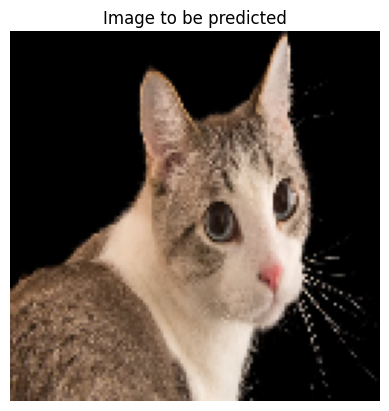

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
This is a cat!


In [24]:
# Load an image you want to predict
img_path = './billu.jpg'
img = image.load_img(img_path, target_size=(128, 128))  # Resize image to match model input shape (128, 128)
img_array = image.img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize the image

# Display the image
plt.imshow(img)  # Display the image using Matplotlib
plt.title("Image to be predicted")
plt.axis('off')  # Hide the axes
plt.show()

# Make a prediction
prediction = model.predict(img_array)

# Interpret the prediction (assuming binary classification)
predicted_class_index = np.argmax(prediction)  # Get the index of the class with the highest probability

if predicted_class_index > 0.5:  
    print("This is a dog!")
else: 
    print("This is a cat!")

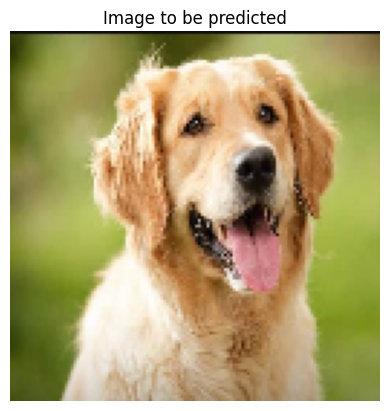

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
This is a dog!


In [20]:
# Load an image you want to predict
img_path = './test_2.jpg'
img = image.load_img(img_path, target_size=(128, 128))  # Resize image to match model input shape (128, 128)
img_array = image.img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize the image

# Display the image
plt.imshow(img)  # Display the image using Matplotlib
plt.title("Image to be predicted")
plt.axis('off')  # Hide the axes
plt.show()

# Make a prediction
prediction = model.predict(img_array)

# Interpret the prediction (assuming binary classification)
predicted_class_index = np.argmax(prediction)  # Get the index of the class with the highest probability

if predicted_class_index > 0.5:  
    print("This is a dog!")
else: 
    print("This is a cat!")